# RQ2: How does the variation in time zones from where developers collaborate influence the speed of code review?

## A. Repository-Level Analysis:
### 1. Statistical analysis of the average pairwise difference
In the below:
- We read the preprocessed data from the corresponding file
- Plot a scatter plot of the data to visually examine the relationship between the independent and dependent variables. This step can help us identify any potential patterns or outliers.
- Perform the Spearman 's Correlation test to check the association between the average pairwise timezone difference and the time-to-merge.
- Perform the Shapiro Wilk & QQ-plot tests for normal distribution (and visualize) on our dependent variable
- Perform the Mann-Whitney U test to see if there is any significant difference between repositories of low average difference and high average difference. To do this we set a threshold, based on the median of the average pairwise timezone difference.

We find out:
- From the scatter plot, we can see that the relationship of our data is not linear.
- From the Spearman's Correlation test, we find that the p-value > 0.05, so we accept the null hypothesis. Thus, there is **no monotonicity between the two variables**.
- That our dependent variable does not follow a ND. This is because the p-value of the Shapiro Wilk test is not higher than 0.05 so we accept the null hypothesis (i.e., **that the data are not normally distributed**). 
- We also see a visualization of the non-normality in the QQ-plot. If the time-to-merge was a ND variable, then the data point would have followed the straight diagonal line. Deviation from the straight line suggests a departure from the expected distribution. In our case, that the data deviate upward from the line, it indicates that the observed data has heavier tails or is more spread out than the theoretical distribution.
- Mann-Whitney U test showed that **there is a statistical significance between the two groups**. This means that the time-to-merge of repositories with low (less than the median aka group 1) average pairwise difference is different from the time-to-merge of the repositories with high (higher than the median aka group 2) timezone difference.
- Next, since we found a statistically significant difference in the above test, the next step is to check whether distribution underlying group 1 is higher/lower than group 2. We perform again the Mann-Whitney U test with the null hypothesis being: 'The distribution underlying group 1 is stochastically greater than the distribution underlying group 2'. We find the p-value to be less than 0.05, so we reject the null hypothesis. Thus, for repositories with low average pairwise timezone difference the time-to-merge is lower than for repositories with higher average pairwise timezone difference. In other words, **repositories with lower average timezone difference have lower time-to-merge than repositories with higher average timezone difference**.

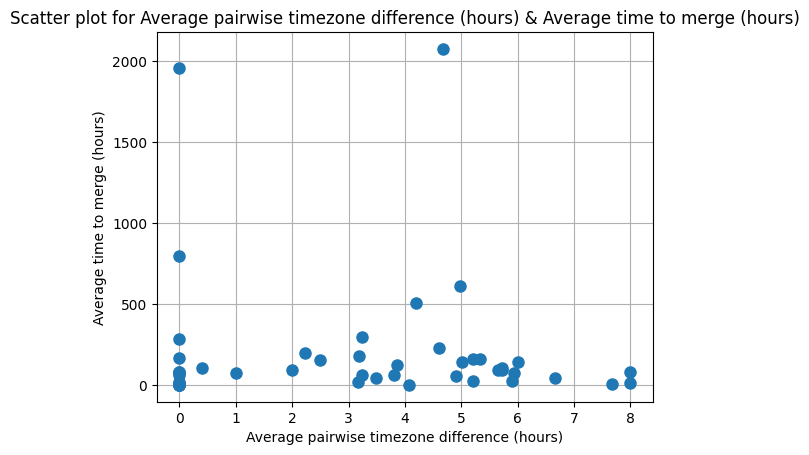

Average time to merge (hours) does not follow a normal distribution (p value = 1.0349549342536513e-11 < 0.05)


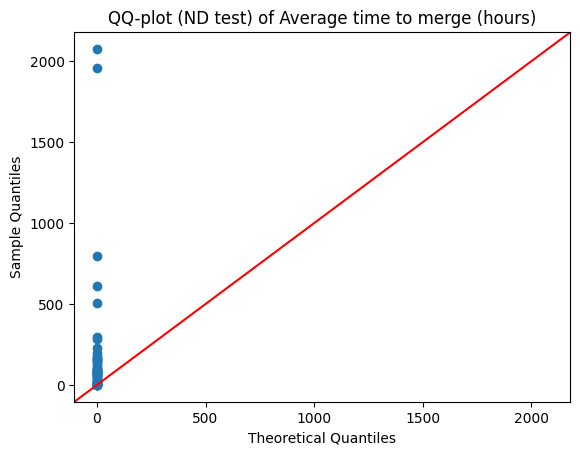

Spearman correlation: 0.04078857858732008
P-value: 0.787821760453125
There is no statistically significant association between the average difference between timezones and the time to merge.
The median of Simpson's Index of Diversity is 3.363472784525416


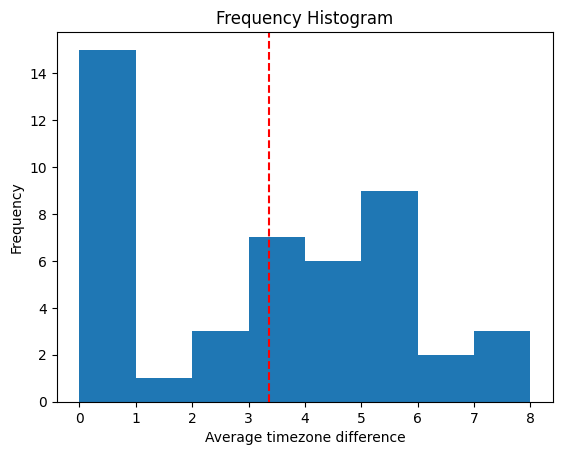

Mann-Whitney U test for H0: group1 != group2
Mann-Whitney U statistic: 0.0
p-value: 4.020106253838594e-09
The difference between the two groups is statistically significant.
Mann-Whitney U test for H0: group1 > group2
Mann-Whitney U statistic: 0.0
p-value: 2.010053126919297e-09


In [2]:
# READ DATA FROM PROCESSED DATASET
import json
import pendulum
import matplotlib.pyplot as plt
from scipy import stats

def tz_diff(city1, city2, on=None):
    """
    Returns the difference in hours between the time zone of city1 and city2.

    As not all time zones are separated by an integer number of hours, this
    function returns a float.

    As time zones are political entities, their definitions can change over time.
    This is complicated by the fact that daylight savings time does not start
    and end on the same days uniformly across the globe. This means that there are
    certain days of the year when the returned value between `Europe/Berlin` and
    `America/New_York` is _not_ `6.0`.

    By default, this function always assumes that you want the current
    definition. If you prefer to specify, set `on` to the date of your choice.
    It should be a `Pendulum` object.

    This function returns the number of hours which must be added to the city1 time
    in order to get the city2 time. For example,
    ```python
    >>> tz_diff('Europe/Berlin', 'America/New_York')
    -6.0
    >>> tz_diff('Europe/Berlin', 'Asia/Kabul')
    2.5
    ```
    """
    if on is None:
        on = pendulum.today()
    diff = (on.set(tz=city1) - on.set(tz=city2)).total_hours()

    # what about the diff from Tokyo to Honolulu? Right now the result is -19.0
    # it should be 5.0; Honolulu is naturally east of Tokyo, just not so around
    # the date line
    if abs(diff) > 12.0:
        if diff < 0.0:
            diff += 24.0
        else:
            diff -= 24.0
    return diff

# Opening JSON file
f = open('data_rqs/RQ1_2_Locations_PR.json')
data = json.load(f)
# x values is the indpendent (timezone difference), y are the dependent (time to merge)
x_values=[]
y_values=[]
for repo in data:
	# get average tz difference (PAIRWISE!)
    locations=repo["locations"]
    tz_sum=0
    pairs_count=0
    for i in range(len(locations)):
        for j in range(i+1, len(locations)):
            tz_sum+=abs(tz_diff(locations[i], locations[j]))
            pairs_count+=1
    if pairs_count!=0: # (avoid div by 0)
        x_values.append(tz_sum/pairs_count)
    elif len(locations) == 1: #only 1 user has locaiton available
        x_values.append(0)
    # get average time-to-merge
    y_values.append(repo["time_to_merge_average"])

def create_dot_plot(x_values, y_values, xlabel, ylabel):
    fig, ax = plt.subplots()
    ax.plot(x_values, y_values, 'o', markersize=8)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    plt.title(f'Scatter plot for {xlabel} & {ylabel}')
    plt.show()
x_label='Average pairwise timezone difference (hours)'
y_label = 'Average time to merge (hours)'
create_dot_plot(x_values, y_values, x_label, y_label)


# Closing file
f.close()

# CHECK IF THE DEPENDENT VARIABLE IS NORMALLY DISTRIBUTED
# SHAPIRO-WILK TEST
from scipy.stats import norm
from scipy.stats import shapiro
import scipy.stats as stats

def test_ShapiroWilk(values, label):
    res = shapiro(values)
    if res.pvalue>0.05: # if true, then normal distibution
        print(f'{label} follows a normal distribution (p value = {res.pvalue} > 0.05)')
    else:
        print(f'{label} does not follow a normal distribution (p value = {res.pvalue} < 0.05)')

test_ShapiroWilk(y_values, y_label)

# QQ-PLOT
import statsmodels.api as sm
import pylab
import numpy as np
def get_QQPlot(values, label):
    values=np.array(values) # data need to be in an array
    sm.qqplot(values, line='45')
    pylab.title(f'QQ-plot (ND test) of {label}')
    pylab.show()

get_QQPlot(y_values, y_label)

# Perform Spearman rank correlation test
def get_Spearman (a, b):
    correlation, p_value = stats.spearmanr(a, b)
    print(f'Spearman correlation: {correlation}')
    print(f'P-value: {p_value}')

    # Interpret the results
    if p_value < 0.05:
        print("There is a statistically significant association between the average difference between timezones and the time to merge.")
    else:
        print("There is no statistically significant association between the average difference between timezones and the time to merge.")
get_Spearman(x_values, y_values)

# MANN-WHITNEY U TEST: 
import statistics
from scipy.stats import mannwhitneyu
median_x_values = statistics.median(x_values) 
print(f'The median of Simpson\'s Index of Diversity is {median_x_values}')
group1, group2=[],[]
for i in x_values:
    if i < median_x_values:
        group1.append(i)
    else:
        group2.append(i)

# histogram of differences to set a threshold
import math
bin_size=1
plt.hist(x_values, bins=range(0, math.ceil(max(x_values))+bin_size, bin_size)) # get bins of size 'bin_size'
plt.gca().set(title='Frequency Histogram', xlabel= 'Average timezone difference', ylabel='Frequency')

# vertical line for threshold (<= and > 4 hours)
# Add a vertical line at a specific x-coordinate
line_position = 4  # x-coordinate where the line should be placed
plt.axvline(x=median_x_values, color='r', linestyle='--')
plt.show()


stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')

print('Mann-Whitney U test for H0: group1 != group2')
print(f"Mann-Whitney U statistic: {stat}")
print(f"p-value: {p_value}")

# Check if the result is statistically significant
if p_value < 0.05:
    print("The difference between the two groups is statistically significant.")
else:
    print("No significant difference between the two groups.")

# Mann-Whitney U-test to see if group 1 > group 2
stat, p_value = mannwhitneyu(group1, group2, alternative='less') # lower is the alternative hypothesis

print('Mann-Whitney U test for H0: group1 > group2')
print(f"Mann-Whitney U statistic: {stat}")
print(f"p-value: {p_value}")


## B. Pull Request-Level Analysis:

In this section, we perform the same steps as above, but instead of doing it in a repository-level, we perform it in a pull request level. Thus, instead of calculating the number of distinct timezones in a repository and the average time-to-merge in the repository, we are calculating the number of timezones of the people that were involved (author, reviewer, commenter) in a PR and the exact time-to-merge of that PR. <br><br>
**Before running this script, make sure to run pr_level_analysis.ipynb, which collects and preprocesses the data for this purpose**


### 1. Retrieve timezone difference from PR data

In this code, we process the data from pr_participation.json from the data directory. Here we measure our data only by pull request, not the repository. 
In the script below, we convert all collaborator locations to their respective UTC timezone. We then retrieve the timezone difference for each pull request.

In [3]:
import pytz
from datetime import datetime, timezone
import json

f = open("data/pr_participation_filtered.json")
location_data = json.load(f)

# Initialize the output dictionary
output_data = []

for item in location_data:
    repo_name = item['repository']
    locations = [k for k, v in item["participants_timezones"].items() for _ in range(v)]
    pairs_count=0
    tz_sum=0
    for i in range(len(locations)):
        for j in range(i+1, len(locations)):
            tz_sum+=abs(tz_diff(locations[i], locations[j]))
            pairs_count+=1
    if pairs_count!=0: # (avoid div by 0)
        timezone_diff = tz_sum/pairs_count
    elif len(locations) == 1: #only 1 user has locaiton available
        timezone_diff = 0

    output_data.append({
        "repository": repo_name,
        "participants_timezones": item['participants_timezones'],
        "time_to_merge": item["time_to_merge"],
        "timezone_diff": timezone_diff
    })

with open("data_rqs/RQ2_pr_participation_timezones.json", "w") as outfile:
    json.dump(output_data, outfile)

print("Result written in data_rqs/RQ2_pr_participation_timezones.json")

Result written in data_rqs/RQ2_pr_participation_timezones.json


### 2. Statistical analysis for pull requests and timezone 


1. We skip the Shapiro-Wilk test to check for normal distribution of time-to-merge, as it is performed above.
2. We perform the Spearman test which shows a statistically **significant association between average timezone pairwise difference and time-to-merge**.
3. We perform a Mann-Whitney U test
   - We compute the median of average pairwise difference within a PR. This value is 0, as we have many Pull Requests that have participants from the same timezone. Group 1 consists of the PRs with average timezone difference <= 0, while group 2 consists of the PRs with average timezone difference > 0.
   - The null hypothesis is that PRs with lower timezone difference (group 1) have lower time-to-merge than PRs with higher timezone difference (group 2).
   - This test is performed on the time to merge and timezone difference of each pull request.
   - The Mann-Whitney U statistic is 0 and the p-value is 1, meaning that **all values in group 1 are lower compared to all the values in  group 2**. We can accept the null hypothesis with 100% confidence (p-value = 1).

Spearman correlation: 0.11293387905812562
P-value: 7.354567592431078e-10
There is a statistically significant association between the average difference between timezones and the time to merge.



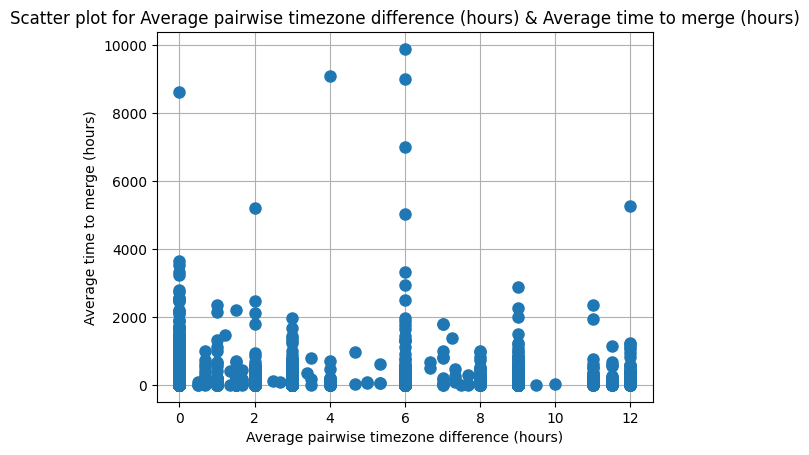

The median value of timezone differences within a PR is 0.0
Mann-Whitney U test for H0: group1 < group2
Mann-Whitney U statistic: 0.0
p-value: 1.0


In [4]:
import json
import matplotlib.pyplot as plt
import scipy.stats as stats

# Load the data
with open("data_rqs/RQ2_pr_participation_timezones.json", "r") as f:
    data = json.load(f)

# Extract the relevant information
timezone_difference = []
time_to_merge = []
for item in data:
    timezone_difference.append(item["timezone_diff"])
    time_to_merge.append(item["time_to_merge"])

# Spearman test
get_Spearman(timezone_difference, time_to_merge)
print()

x_label='Average pairwise timezone difference (hours)'
y_label = 'Average time to merge (hours)'
create_dot_plot(timezone_difference, time_to_merge, x_label, y_label)

# Mann-Whitney U test
median_value = statistics.median(timezone_difference) 
print(f'The median value of timezone differences within a PR is {median_value}')
group1, group2=[],[]
for i in timezone_difference:
    if i <= median_value:
        group1.append(i)
    else:
        group2.append(i)

stat, p_value = mannwhitneyu(group1, group2, alternative='greater') # greater is the alternative hypothesis

print('Mann-Whitney U test for H0: group1 < group2')
print(f"Mann-Whitney U statistic: {stat}")
print(f"p-value: {p_value}")